In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *
from fastai.models.resnet import vgg_resnet50

import json

In [3]:
#torch.cuda.set_device(2)

In [4]:
torch.backends.cudnn.benchmark=True

## Data

In [5]:
PATH = Path('/home/giles/Downloads/fastai_data/salt/')
MASKS_FN = 'train_masks.csv'
META_FN = 'metadata.csv'
masks_csv = pd.read_csv(PATH/MASKS_FN)
meta_csv = pd.read_csv(PATH/META_FN)

In [6]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [7]:
(PATH/'train_masks-128').mkdir(exist_ok=True)

In [8]:
def resize_img(fn):
    Image.open(fn).resize((128,128)).save((fn.parent.parent)/'train_masks-128'/fn.name)

files = list((PATH/'train_masks').iterdir())
with ThreadPoolExecutor(8) as e: e.map(resize_img, files)

In [9]:
(PATH/'train-128').mkdir(exist_ok=True)

In [10]:
def resize_img(fn):
    Image.open(fn).resize((128,128)).save((fn.parent.parent)/'train-128'/fn.name)

files = list((PATH/'train').iterdir())
with ThreadPoolExecutor(8) as e: e.map(resize_img, files)

In [11]:
TRAIN_DN = 'train-128'
MASKS_DN = 'train_masks-128'
sz = 32
bs = 64
nw = 16

TRAIN_DN = 'train'
MASKS_DN = 'train_masks_png'
sz = 128
bs = 64
nw = 16

In [12]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0

In [13]:
x_names = np.array(glob(f'{PATH}/{TRAIN_DN}/*'))
y_names = np.array(glob(f'{PATH}/{MASKS_DN}/*'))

In [14]:
val_idxs = list(range(800))
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)

In [15]:
aug_tfms = [RandomFlip(tfm_y=TfmType.CLASS)]

In [16]:
tfms = tfms_from_model(resnext50, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

In [17]:
x,y = next(iter(md.trn_dl))

In [18]:
x.shape,y.shape

(torch.Size([64, 3, 32, 32]), torch.Size([64, 32, 32]))

In [19]:
denorm = md.val_ds.denorm

In [20]:
def show_aug_img(ims, idx, figsize=(5,5), normed=True, ax=None, nchannels=3):
    if ax is None: fig,ax = plt.subplots(figsize=figsize)
    if normed: ims = denorm(ims)
    else:      ims = np.rollaxis(to_np(ims),1,nchannels+1)
    ax.imshow(np.clip(ims,0,1)[idx])
    ax.axis('off')

In [21]:
batches = [next(iter(md.aug_dl)) for i in range(9)]

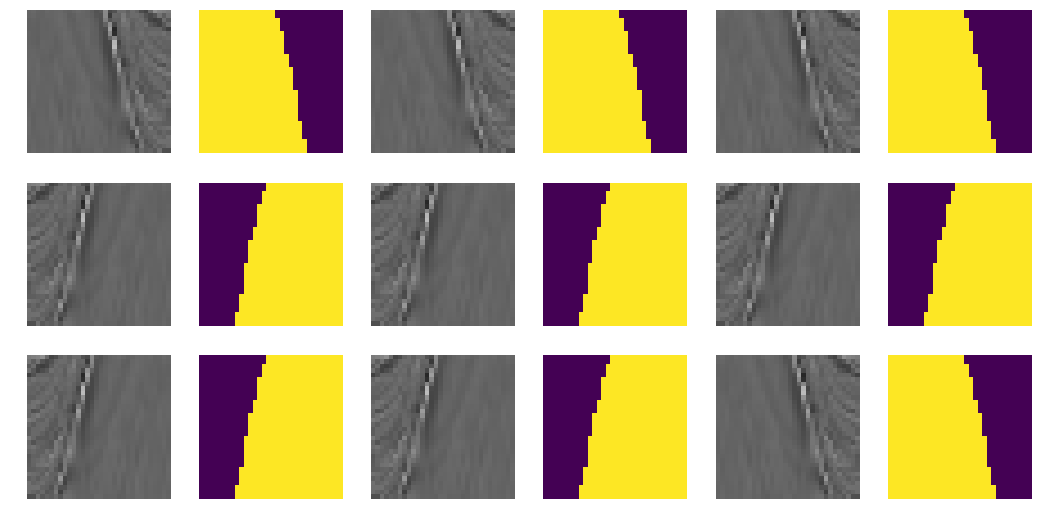

In [22]:
fig, axes = plt.subplots(3, 6, figsize=(18, 9))
for i,(x,y) in enumerate(batches):
    show_aug_img(x,1, ax=axes.flat[i*2])
    show_aug_img(y,1, ax=axes.flat[i*2+1], nchannels=1, normed=False)

## Simple upsample

In [23]:
f = resnext50
cut,lr_cut = model_meta[f]

In [24]:
def get_base():
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers)

In [25]:
def dice(pred, targs):
    pred = (pred>0.5).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

## U-net (ish)

In [26]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [27]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p))

In [28]:
class Unet34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(2048,1024,256)
        self.up2 = UnetBlock(256,512,256)
        self.up3 = UnetBlock(256,256,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = UnetBlock(256,3,16)
        self.up6 = nn.ConvTranspose2d(16, 1, 1)
        
    def forward(self,x):
        inp = x
        x = F.relu(self.rn(x))
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x, inp)
        x = self.up6(x)
        return x[:,0]
    
    def close(self):
        for sf in self.sfs: sf.remove()

In [29]:
class UnetModel():
    def __init__(self,model,name='unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model)[1:]]

## Training loop

In [30]:
def trainModel(uid, models, trn_x, trn_y, val_x,val_y, aug_tfms, lr=2e-2, wd=1e-7, bs=64):
    ##32
    print('Running on 32x32')
    sz = 32
    tfms = tfms_from_model(resnext50, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
    datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
    md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
    denorm = md.trn_ds.denorm
    
    learn = ConvLearner(md, models)
    learn.opt_fn=optim.Adam
    learn.crit=nn.BCEWithLogitsLoss()
    learn.metrics=[dice, accuracy_thresh(0.5)]
    
    learn.freeze_to(1)
    lrs = np.array([lr/9,lr/3,lr])
    learn.fit(lr,1,wds=wd,cycle_len=8,use_clr=(5,8), best_save_name='tmp')
    learn.load('tmp')
    learn.unfreeze()
    learn.bn_freeze(True)
    learn.fit(lrs/2, 1, wds=wd, cycle_len=20,use_clr=(20,10), best_save_name='tmp')
    
    ##64
    print('Running on 64x64')
    sz = 64
    tfms = tfms_from_model(resnext50, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
    datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
    md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
    
    learn = ConvLearner(md, models)
    learn.opt_fn=optim.Adam
    learn.crit=nn.BCEWithLogitsLoss()
    learn.metrics=[dice, accuracy_thresh(0.5)]
    learn.load('tmp')
    
    learn.freeze_to(1)
    learn.fit(lr/2,1,wds=wd, cycle_len=10,use_clr=(10,10), best_save_name='tmp')
    learn.load('tmp')
    learn.unfreeze()
    learn.bn_freeze(True)
    learn.fit(lrs/4,1,wds=wd, cycle_len=8,use_clr=(20,8), best_save_name='tmp')
    
    ##128
    print('Running on 128x128')
    sz = 128
    tfms = tfms_from_model(resnext50, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
    datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
    md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
    
    learn = ConvLearner(md, models)
    learn.opt_fn=optim.Adam
    learn.crit=nn.BCEWithLogitsLoss()
    learn.metrics=[dice, accuracy_thresh(0.5)]
    learn.load('tmp')
    
    learn.freeze_to(1)
    learn.fit(lr/2,1, wds=wd, cycle_len=6,use_clr=(6,4), best_save_name='tmp')
    learn.load('tmp')
    learn.unfreeze()
    learn.bn_freeze(True)
    learn.fit(lrs/5,1, wds=wd,cycle_len=8,use_clr=(20,8), best_save_name='tmp')
    learn.load('tmp')
    learn.fit(lrs/5,5, wds=wd,cycle_len=1,cycle_mult=2, best_save_name='model_'+str(uid))

In [31]:
from sklearn.model_selection import KFold

In [32]:
nSplits = 10

sz = 32
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)
tfms = tfms_from_model(resnext50, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[dice, accuracy_thresh(0.5)]

learn.freeze_to(1)
learn.lr_find()
learn.sched.plot()

In [41]:
kf = KFold(n_splits=nSplits, shuffle=True)
folds = kf.split(trn_x)
for i, (train, test) in enumerate(folds):
    print('_____________________________')
    print('Running fold', i+1,'/', nSplits)
    m_base = get_base()
    m = to_gpu(Unet34(m_base))
    models = UnetModel(m)
    trainModel(i, models, trn_x[train], trn_y[train], trn_x[test], trn_y[test], aug_tfms, lr=5e-2)
    print('_____________________________')

_____________________________
Running fold 1 / 10
Running on 32x32


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.323881   5.182371   0.505113   0.764789  
    1      0.25942    0.215268   0.826838   0.915607       
    2      0.228952   0.216838   0.833537   0.916089       
    3      0.206294   0.215998   0.816081   0.911447       
    4      0.190013   0.19005    0.843023   0.923407       
    5      0.171867   0.197121   0.845153   0.924802       
    6      0.161124   0.19266    0.846459   0.921573       
    7      0.147548   0.167002   0.870238   0.932782       


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.269767   0.285575   0.769053   0.888544  
    1      0.271222   0.356858   0.522292   0.821448       
    2      0.31027    0.250636   0.814288   0.907251       
    3      0.289575   0.323526   0.709736   0.873865       
    4      0.284377   0.238154   0.821793   0.910104       
    5      0.251596   0.194356   0.837961   0.919662       
    6      0.225046   0.237539   0.801386   0.904391       
    7      0.230495   0.22562    0.839936   0.918469       
    8      0.211253   0.233621   0.784104   0.901779       
    9      0.20093    0.221991   0.784507   0.900421       
    10     0.176348   0.180143   0.86895    0.931195       
    11     0.176002   0.192211   0.84805    0.923874       
    12     0.165002   0.209251   0.8322     0.916959       
    13     0.149676   0.175602   0.85077    0.92756        
    14     0.143903   0.232568   0.852277   0.916995       
    15     0.13542    0.166661   0.881451   0

epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.247092   0.230172   0.847025   0.920286  
    1      0.220848   0.22179    0.81099    0.910574       
    2      0.2036     0.18301    0.864967   0.930672       
    3      0.190492   0.177415   0.865115   0.931651       
    4      0.178365   0.211181   0.844641   0.923969       
    5      0.173269   0.183612   0.859371   0.929518       
    6      0.162513   0.169656   0.867158   0.933318       
    7      0.15671    0.172164   0.872056   0.934888       
    8      0.148995   0.173327   0.875836   0.936479       
    9      0.141198   0.16657    0.878132   0.937498       


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.164533   0.255658   0.830515   0.908718  
    1      0.186322   0.163878   0.859567   0.929493       
    2      0.175997   0.169735   0.88454    0.938172       
    3      0.160705   0.163154   0.873059   0.93568        
    4      0.141184   0.139131   0.887425   0.942263       
    5      0.124807   0.150355   0.890681   0.941666       
    6      0.11251    0.143319   0.896183   0.945304       
    7      0.097067   0.159043   0.891404   0.942085        
Running on 128x128


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.221059   0.185893   0.852172   0.924385  
    1      0.212556   0.295216   0.700093   0.872388       
    2      0.209561   0.270727   0.759017   0.892307       
    3      0.196538   0.172001   0.855238   0.928337       
    4      0.18184    0.166824   0.861515   0.930928       
    5      0.168358   0.163202   0.877583   0.936323       


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.172159   0.195076   0.851065   0.923086  
    1      0.174382   0.202738   0.808136   0.909349       
    2      0.166178   0.172852   0.847789   0.926267       
    3      0.154858   0.178691   0.83789    0.922364       
    4      0.148914   0.169704   0.875123   0.934568       
    5      0.136982   0.142051   0.892236   0.945325       
    6      0.118439   0.141451   0.888525   0.943184       
    7      0.107251   0.141645   0.898196   0.947373       


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.155049   0.147008   0.883529   0.940436  
    1      0.15795    0.147963   0.886042   0.941731       
    2      0.133488   0.14184    0.89229    0.944621       
    3      0.135952   0.14637    0.873601   0.936783       
    4      0.128199   0.153115   0.88697    0.941462       
    5      0.113318   0.179531   0.876204   0.937791       
    6      0.095173   0.144203   0.890486   0.942771        
    7      0.12023    0.166355   0.869559   0.934184        
    8      0.126512   0.161563   0.884449   0.93958        
    9      0.123514   0.165933   0.880586   0.938739       
    10     0.112503   0.17153    0.888539   0.942382       
    11     0.10262    0.144643   0.890435   0.943615       
    12     0.086915   0.15683    0.893004   0.944476        
    13     0.074091   0.166312   0.891496   0.944183        
    14     0.067439   0.16234    0.891864   0.944156        
    15     0.111389   0.196146   0.79441

epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.334188   0.715198   0.634946   0.746808  
    1      0.27112    0.287442   0.775299   0.892853       
    2      0.235913   0.275551   0.801398   0.902127       
    3      0.213414   0.268808   0.788401   0.904431       
    4      0.197346   0.230975   0.811972   0.914264       
    5      0.176469   0.26918    0.794219   0.901434       
    6      0.16516    0.234423   0.823328   0.916614       
    7      0.150498   0.249795   0.81817    0.917389       


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.248598   0.235374   0.777285   0.901871  
    1      0.246244   0.316361   0.793365   0.893573       
    2      0.353586   0.352037   0.595115   0.843149       
    3      0.317042   0.284554   0.755178   0.890872       
    4      0.264554   0.240826   0.792805   0.904318       
    5      0.23575    0.256683   0.747318   0.892215       
    6      0.215492   0.257659   0.814475   0.907166       
    7      0.20666    0.249257   0.75406    0.893622       
    8      0.202628   0.239507   0.803191   0.910028       
    9      0.183086   0.259624   0.803379   0.911011       
    10     0.178486   0.225132   0.833856   0.919223       
    11     0.164733   0.20402    0.842193   0.923779       
    12     0.15251    0.240854   0.830212   0.918979       
    13     0.145753   0.244333   0.839695   0.923663       
    14     0.129949   0.236613   0.850122   0.924188       
    15     0.113877   0.236658   0.841353   0

epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.291383   0.291178   0.69365    0.8731    
    1      0.24042    0.234392   0.803472   0.909127       
    2      0.210063   0.213062   0.820858   0.916356       
    3      0.191931   0.209058   0.835525   0.920712       
    4      0.179977   0.202777   0.832632   0.920637       
    5      0.17118    0.197836   0.837728   0.923302       
    6      0.15974    0.206748   0.85207    0.927475       
    7      0.152241   0.2067     0.846819   0.925133       
    8      0.144499   0.202867   0.841389   0.922979       
    9      0.137373   0.205076   0.84405    0.92328        


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.188739   0.343201   0.641236   0.859637  
    1      0.203752   0.221671   0.832284   0.916939       
    2      0.184684   0.222396   0.842467   0.917168       
    3      0.160899   0.214277   0.848906   0.925649       
    4      0.139752   0.211978   0.84679    0.925461       
    5      0.122864   0.231029   0.845714   0.922094       
    6      0.114772   0.198953   0.867776   0.934125       
    7      0.098561   0.20388    0.880357   0.939184        
Running on 128x128


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.232481   0.23132    0.801824   0.908598  
    1      0.210572   0.216051   0.816512   0.914285       
    2      0.188955   0.221889   0.812003   0.914231       
    3      0.17621    0.203674   0.832459   0.920305       
    4      0.172904   0.243501   0.828523   0.911862       
    5      0.166083   0.208445   0.830506   0.920836       


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.179165   0.437857   0.614179   0.847995  
    1      0.21812    0.247256   0.819238   0.907299       
    2      0.183123   0.219512   0.833412   0.916632       
    3      0.159845   0.187061   0.860683   0.931329       
    4      0.148525   0.183025   0.865849   0.933922       
    5      0.139341   0.195335   0.858154   0.930439       
    6      0.125131   0.21722    0.85425    0.929661       
    7      0.112248   0.190342   0.868966   0.93375        


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.162457   0.178668   0.856838   0.930689  
    1      0.150986   0.200351   0.855083   0.930101       
    2      0.127243   0.198539   0.865029   0.933219       
    3      0.13985    0.226063   0.839782   0.920861       
    4      0.14124    0.24819    0.831995   0.919092       
    5      0.121508   0.220104   0.855816   0.92926        
    6      0.101822   0.214554   0.856481   0.928675       
    7      0.122413   0.22485    0.810417   0.913496        
    8      0.13496    0.220828   0.818211   0.908188       
    9      0.12973    0.210161   0.862785   0.93356        
    10     0.113485   0.234665   0.853914   0.929639       
    11     0.099529   0.254969   0.861696   0.932288        
    12     0.085868   0.225844   0.861391   0.931773        
    13     0.073992   0.237306   0.859612   0.930864        
    14     0.067122   0.236662   0.861372   0.931611        
    15     0.097618   0.245877   0.82228

epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.327037   1.781849   0.664469   0.806564  
    1      0.261266   0.253756   0.778142   0.902759       
    2      0.233775   0.264622   0.791414   0.901605       
    3      0.211047   0.209561   0.801347   0.917154       
    4      0.188633   0.22884    0.815143   0.917517       
    5      0.170996   0.208053   0.815245   0.920355       
    6      0.153844   0.234792   0.817279   0.918817       
    7      0.135443   0.207592   0.839057   0.929538       


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.281955   0.22825    0.79744    0.914981  
    1      0.291882   0.527686   0.196997   0.791983       
    2      0.468872   0.541478   0.0        0.768536       
    3      0.523794   0.542545   0.0        0.768536       
    4      0.543179   0.539145   0.0        0.768536       
    5      0.549763   0.539343   0.0        0.768536       
    6      0.553436   0.539309   0.0        0.768536       
    7      0.552277   0.538581   0.0        0.768536       
    8      0.554489   0.540859   0.0        0.768536       
    9      0.553685   0.538547   0.0        0.768536       
    10     0.553282   0.539817   0.0        0.768536       
    11     0.552726   0.538237   0.0        0.768536       
    12     0.552039   0.538578   0.0        0.768536       
    13     0.554734   0.542158   0.0        0.768536       
    14     0.554096   0.541915   0.0        0.768536       
    15     0.553342   0.538921   0.0        0

epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.289789   0.221047   0.803277   0.918018  
    1      0.29405    0.243694   0.770021   0.907806       
    2      0.25626    0.269903   0.693557   0.888087       
    3      0.239148   0.190296   0.834905   0.928831       
    4      0.212661   0.192762   0.831493   0.92637        
    5      0.200454   0.183652   0.845392   0.931731       
    6      0.185098   0.176843   0.846289   0.931841       
    7      0.175241   0.175219   0.846515   0.932863       
    8      0.166847   0.167486   0.846826   0.934172       
    9      0.160446   0.16057    0.856619   0.936674       


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.255453   0.21742    0.813445   0.920501  
    1      0.218264   0.189497   0.832508   0.929008       
    2      0.201237   0.25814    0.674324   0.880234       
    3      0.186498   0.220515   0.85654    0.936681       
    4      0.168293   0.15471    0.864139   0.94108        
    5      0.150117   0.156613   0.86551    0.940574       
    6      0.132612   0.1407     0.874236   0.945552       
    7      0.115984   0.147148   0.880312   0.946574       
Running on 128x128


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.201966   0.17588    0.845004   0.932718  
    1      0.224512   0.260015   0.64463    0.875437       
    2      0.212386   0.19662    0.851399   0.932917       
    3      0.18625    0.1639     0.86101    0.938085       
    4      0.173096   0.175479   0.849687   0.932652       
    5      0.161543   0.155679   0.857122   0.937193       


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.191494   0.191058   0.81       0.920312  
    1      0.201792   0.174756   0.838542   0.931447       
    2      0.18302    0.157392   0.84715    0.93535        
    3      0.16157    0.163055   0.865995   0.940554       
    4      0.147416   0.165228   0.86974    0.941279       
    5      0.135178   0.150098   0.872626   0.942599       
    6      0.125137   0.14468    0.881249   0.946921       
    7      0.109266   0.132654   0.886567   0.948351       


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.238374   0.212971   0.833075   0.928279  
    1      0.196238   0.152239   0.862512   0.939979       
    2      0.154928   0.139285   0.879556   0.946852       
    3      0.150515   0.18243    0.863573   0.937406       
    4      0.144715   0.144007   0.856789   0.938485       
    5      0.127411   0.131399   0.889549   0.950414       
    6      0.106282   0.132623   0.894915   0.952646       
    7      0.13785    0.173172   0.836768   0.93106        
    8      0.144783   0.161148   0.857003   0.939045       
    9      0.137342   0.134115   0.876774   0.945774       
    10     0.121839   0.164708   0.87397    0.942747       
    11     0.107374   0.140286   0.880683   0.946272       
    12     0.092493   0.154512   0.885662   0.948508        
    13     0.077587   0.145454   0.887258   0.949073        
    14     0.069491   0.143413   0.889911   0.950284        
    15     0.205738   0.254447   0.791456 

epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.338682   7.493218   0.562879   0.613834  
    1      0.268682   0.217447   0.83079    0.913654       
    2      0.233758   0.206071   0.809524   0.91225        
    3      0.217714   0.203831   0.827116   0.918555       
    4      0.194643   0.212766   0.832214   0.919162       
    5      0.180572   0.235501   0.842446   0.917792       
    6      0.161301   0.186595   0.845005   0.925034       
    7      0.149154   0.184812   0.855      0.927859       


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.272353   0.226817   0.817258   0.909052  
    1      0.265879   0.379711   0.757484   0.863617       
    2      0.285486   0.278124   0.701709   0.87478        
    3      0.246428   0.204284   0.85443    0.929282       
    4      0.227824   0.244312   0.717217   0.883167       
    5      0.221647   0.191957   0.847691   0.924289       
    6      0.227331   0.24165    0.752986   0.892712       
    7      0.203253   0.17849    0.863406   0.933426       
    8      0.194324   0.194893   0.841477   0.922794       
    9      0.170111   0.172929   0.859771   0.931076       
    10     0.161451   0.194845   0.822317   0.919006       
    11     0.148421   0.171768   0.859026   0.932025       
    12     0.139231   0.166904   0.858692   0.931454       
    13     0.128494   0.162094   0.865417   0.93215        
    14     0.119836   0.163473   0.873108   0.934576       
    15     0.104245   0.167311   0.873581   0

epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.262642   0.207741   0.866581   0.929705  
    1      0.217215   0.173501   0.841303   0.924696       
    2      0.200036   0.157332   0.876664   0.938823       
    3      0.191107   0.170208   0.877366   0.938225       
    4      0.176204   0.158329   0.870016   0.936287       
    5      0.169706   0.159658   0.885431   0.940307       
    6      0.161722   0.155132   0.885631   0.940514       
    7      0.154086   0.151779   0.891258   0.94321        
    8      0.146347   0.162927   0.8885     0.941366       
    9      0.135273   0.147872   0.890659   0.94323        


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.174224   0.153628   0.880068   0.940128  
    1      0.183238   0.156869   0.873607   0.936577       
    2      0.165652   0.188174   0.886519   0.938852       
    3      0.157793   0.142136   0.894879   0.946647       
    4      0.147524   0.150663   0.895916   0.946484       
    5      0.126592   0.163578   0.895111   0.944415       
    6      0.106154   0.1385     0.899036   0.947822       
    7      0.091811   0.139366   0.908389   0.9519          
Running on 128x128


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.221374   0.189985   0.872082   0.935789  
    1      0.245708   0.232821   0.852376   0.923522       
    2      0.228635   0.191609   0.866988   0.933125       
    3      0.209612   0.17339    0.878952   0.938121       
    4      0.189968   0.175148   0.879548   0.938256       
    5      0.175114   0.159919   0.887181   0.942561       


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.172383   0.193892   0.87233    0.934467  
    1      0.181528   0.160864   0.883512   0.941225       
    2      0.170008   0.150773   0.878684   0.939252       
    3      0.159526   0.145966   0.890028   0.944781       
    4      0.145284   0.142859   0.895977   0.947013       
    5      0.130065   0.134566   0.902326   0.950005       
    6      0.11516    0.131042   0.903832   0.950142       
    7      0.100665   0.14359    0.90127    0.94987        


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.135052   0.141653   0.898407   0.94794   
    1      0.134536   0.145891   0.89321    0.94666        
    2      0.115829   0.137637   0.902617   0.950479       
    3      0.126761   0.157185   0.867758   0.935633       
    4      0.123196   0.14275    0.896959   0.947933       
    5      0.105064   0.154753   0.901978   0.949019       
    6      0.089039   0.135474   0.906672   0.951421        
    7      0.11599    0.18581    0.877395   0.938948        
    8      0.138523   0.177948   0.851527   0.927399       
    9      0.134659   0.137533   0.901536   0.949961       
    10     0.115852   0.143771   0.906378   0.951293       
    11     0.095713   0.136801   0.912741   0.954765        
    12     0.081809   0.152808   0.906943   0.951818        
    13     0.071063   0.14877    0.907928   0.952085        
    14     0.065514   0.153195   0.907445   0.952065        
    15     0.098105   0.234869   0.8624

epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.323687   2.761384   0.595773   0.685648  
    1      0.255663   1.941119   0.519024   0.818436       
    2      0.230888   0.32644    0.78082    0.880954       
    3      0.209063   0.225645   0.80728    0.910938       
    4      0.187549   0.284659   0.705212   0.879401       
    5      0.176961   0.239052   0.820233   0.909564       
    6      0.159438   0.240362   0.823789   0.910468       
    7      0.140313   0.24308    0.804398   0.91041        


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.247579   0.309121   0.653171   0.863385  
    1      0.28456    0.375519   0.504435   0.82515        
    2      0.272181   0.271313   0.745223   0.890198       
    3      0.245256   0.259128   0.727922   0.884393       
    4      0.225531   0.258469   0.783766   0.899026       
    5      0.21865    0.26045    0.813831   0.909433       
    6      0.205148   0.244768   0.799383   0.908621       
    7      0.196404   0.248718   0.772914   0.8995         
    8      0.178458   0.241905   0.816658   0.91257        
    9      0.163642   0.280602   0.762344   0.891144       
    10     0.155867   0.247267   0.829505   0.91507        
    11     0.152383   0.221887   0.827218   0.918951       
    12     0.137373   0.229703   0.837499   0.922733       
    13     0.12538    0.282567   0.788013   0.903778       
    14     0.117527   0.268558   0.807316   0.911191       
    15     0.104004   0.278839   0.813282   0

epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.252825   0.242238   0.785921   0.903213  
    1      0.218584   0.215813   0.821415   0.916537       
    2      0.195389   0.21039    0.844088   0.923734       
    3      0.183852   0.208566   0.795777   0.90894        
    4      0.173113   0.214195   0.8447     0.924973       
    5      0.160051   0.201625   0.819933   0.918317       
    6      0.150395   0.200964   0.850398   0.929234       
    7      0.137644   0.214554   0.829169   0.921008       
    8      0.129093   0.2044     0.841478   0.924291       
    9      0.119707   0.212745   0.855435   0.928722       


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.1489     0.199297   0.815031   0.914501  
    1      0.168413   0.201133   0.850027   0.926083       
    2      0.160622   0.182409   0.846153   0.926386       
    3      0.136672   0.188227   0.841541   0.926817       
    4      0.120168   0.193071   0.851489   0.929008       
    5      0.102452   0.203911   0.854855   0.931773       
    6      0.091141   0.18165    0.872035   0.937476        
    7      0.079124   0.199565   0.870476   0.937338        
Running on 128x128


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.216313   0.240996   0.805385   0.911295  
    1      0.200994   0.234354   0.782139   0.904047       
    2      0.188509   0.238619   0.796437   0.909377       
    3      0.177018   0.224892   0.824544   0.918446       
    4      0.165624   0.209173   0.833679   0.92137        
    5      0.156969   0.210103   0.83405    0.921414       


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.164381   0.244031   0.839426   0.919535  
    1      0.164192   0.216439   0.827771   0.918958       
    2      0.14698    0.195584   0.8456     0.925723       
    3      0.142347   0.200201   0.833699   0.921873       
    4      0.132575   0.199826   0.847417   0.927135       
    5      0.118116   0.196336   0.859389   0.931852       
    6      0.10453    0.187219   0.850112   0.928955       
    7      0.090553   0.196073   0.859752   0.932756        


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.122661   0.193846   0.846243   0.927112  
    1      0.121764   0.207239   0.841681   0.923599       
    2      0.098076   0.19136    0.860536   0.931475        
    3      0.134577   0.197541   0.837824   0.922832        
    4      0.124855   0.181855   0.866537   0.935982       
    5      0.104048   0.182137   0.868603   0.935722       
    6      0.087116   0.182209   0.87207    0.936683        
    7      0.122668   0.217381   0.822586   0.917602        
    8      0.128865   0.188779   0.837818   0.926238       
    9      0.120305   0.202475   0.86229    0.932285       
    10     0.112796   0.187685   0.844997   0.92721        
    11     0.099551   0.198524   0.865342   0.932657        
    12     0.084504   0.198529   0.868475   0.936105        
    13     0.071553   0.20484    0.872762   0.937935        
    14     0.06425    0.205965   0.873993   0.938122        
    15     0.082288   0.243179   0.84

epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.329103   3.87299    0.557945   0.637131  
    1      0.272489   0.246195   0.81306    0.91405        
    2      0.237208   0.25245    0.825041   0.914508       
    3      0.214454   0.209219   0.845184   0.922369       
    4      0.19725    0.220427   0.818496   0.919141       
    5      0.180126   0.20903    0.835596   0.922879       
    6      0.162144   0.183976   0.833425   0.924402       
    7      0.151904   0.191758   0.840979   0.927499       


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.263251   0.283429   0.696359   0.881308  
    1      0.275185   0.323309   0.51946    0.832562       
    2      0.30429    0.249837   0.7272     0.889279       
    3      0.254924   0.191149   0.810004   0.915543       
    4      0.281148   0.49407    0.265464   0.776086       
    5      0.325299   0.267062   0.760101   0.893112       
    6      0.29023    0.253718   0.79315    0.905042       
    7      0.258176   0.224943   0.748109   0.895316       
    8      0.236739   0.21503    0.82539    0.917694       
    9      0.211507   0.196792   0.830817   0.922879       
    10     0.199104   0.214315   0.858929   0.927762       
    11     0.187008   0.191759   0.816815   0.918048       
    12     0.166366   0.226778   0.77921    0.906146       
    13     0.170678   0.178946   0.864835   0.936609       
    14     0.152544   0.246894   0.790867   0.907629       
    15     0.138641   0.206584   0.858643   0

epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.28719    0.21736    0.798018   0.909114  
    1      0.250985   0.21       0.789474   0.908833       
    2      0.231389   0.202722   0.797828   0.912132       
    3      0.21618    0.194546   0.85557    0.928424       
    4      0.208083   0.176862   0.852731   0.931384       
    5      0.196605   0.175359   0.850992   0.930675       
    6      0.188503   0.171184   0.851054   0.931257       
    7      0.183931   0.170888   0.862161   0.935491       
    8      0.180224   0.167986   0.865187   0.936474       
    9      0.171973   0.169406   0.86656    0.937463       


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.187429   0.173631   0.825818   0.922738  
    1      0.183313   0.195982   0.803605   0.915063       
    2      0.175446   0.170198   0.878718   0.94063        
    3      0.168544   0.182907   0.856842   0.930058       
    4      0.150657   0.136123   0.898755   0.949861       
    5      0.137138   0.160677   0.877312   0.941021       
    6      0.120771   0.156682   0.889072   0.947249       
    7      0.10622    0.145719   0.893826   0.94836        
Running on 128x128


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.25404    0.207589   0.830828   0.9222    
    1      0.236495   0.231098   0.745519   0.895066       
    2      0.221899   0.206256   0.813468   0.917073       
    3      0.211861   0.193949   0.839127   0.926556       
    4      0.200962   0.177868   0.846453   0.929862       
    5      0.191968   0.179523   0.856982   0.932822       


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.190586   0.197888   0.828834   0.921286  
    1      0.199965   0.178384   0.858799   0.933257       
    2      0.187882   0.173141   0.882113   0.940139       
    3      0.1728     0.18031    0.844162   0.929345       
    4      0.167488   0.156115   0.87482    0.940623       
    5      0.152899   0.157071   0.877292   0.939789       
    6      0.140712   0.149941   0.886142   0.945049       
    7      0.128923   0.14735    0.892287   0.946827       


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.165243   0.16076    0.870609   0.937749  
    1      0.156259   0.16157    0.872325   0.939551       
    2      0.137211   0.144233   0.889456   0.945656       
    3      0.154638   0.17068    0.847967   0.93188        
    4      0.159542   0.155873   0.884576   0.943196       
    5      0.143079   0.160267   0.877351   0.941455       
    6      0.125299   0.155664   0.893041   0.94699        
    7      0.145101   0.179019   0.872632   0.938164       
    8      0.157979   0.164044   0.890099   0.944592       
    9      0.148716   0.165908   0.874629   0.939536       
    10     0.139013   0.15517    0.879703   0.941508       
    11     0.121746   0.16233    0.885447   0.944658       
    12     0.105028   0.165779   0.888522   0.945609       
    13     0.092983   0.153843   0.898211   0.950098        
    14     0.086226   0.157991   0.896874   0.94961         
    15     0.122261   0.159653   0.888646  

epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.329122   10.689386  0.489571   0.5095    
    1      0.266819   0.232691   0.80073    0.910886       
    2      0.23508    0.236752   0.812456   0.912796       
    3      0.211206   0.198074   0.80506    0.917307       
    4      0.191658   0.234181   0.751548   0.901419       
    5      0.172372   0.198758   0.793892   0.916397       
    6      0.156936   0.187079   0.829865   0.926398       
    7      0.140851   0.187333   0.822469   0.923813       


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.30705    0.252548   0.773154   0.906015  
    1      0.261258   0.303784   0.788736   0.896912       
    2      0.287672   0.275575   0.656322   0.874722       
    3      0.267093   0.240822   0.767343   0.90477        
    4      0.225988   0.203582   0.8331     0.922583       
    5      0.214618   0.209762   0.813372   0.918137       
    6      0.201186   0.331941   0.713035   0.887372       
    7      0.191984   0.218498   0.771748   0.909616       
    8      0.174895   0.200752   0.794507   0.916791       
    9      0.162827   0.187483   0.83898    0.928601       
    10     0.160846   0.194007   0.818371   0.924243       
    11     0.14437    0.168945   0.844542   0.932709       
    12     0.135702   0.2113     0.824735   0.921176       
    13     0.13486    0.199915   0.805388   0.921744       
    14     0.11855    0.203194   0.82725    0.926993       
    15     0.103858   0.178052   0.852823   0

epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.25544    0.228143   0.793349   0.913043  
    1      0.221349   0.209489   0.800087   0.917435       
    2      0.202846   0.204975   0.813977   0.91854        
    3      0.193135   0.19462    0.804202   0.920294       
    4      0.175813   0.183014   0.840471   0.930871       
    5      0.168674   0.183996   0.836389   0.927306       
    6      0.156682   0.179616   0.841909   0.93209        
    7      0.143941   0.186845   0.84004    0.927772       
    8      0.132954   0.187149   0.846959   0.933985       
    9      0.124081   0.180647   0.845345   0.933626       


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.168396   0.226648   0.829104   0.922541  
    1      0.170025   0.272232   0.744991   0.898818       
    2      0.168239   0.208613   0.84495    0.929408       
    3      0.149549   0.172754   0.850765   0.93424        
    4      0.131729   0.167846   0.849171   0.935744       
    5      0.115021   0.173265   0.856617   0.932906       
    6      0.102789   0.164447   0.863134   0.938708       
    7      0.085552   0.168163   0.876387   0.944874        
Running on 128x128


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.216049   0.191829   0.82215    0.926304  
    1      0.203463   0.215583   0.812604   0.921924       
    2      0.191465   0.212361   0.82811    0.92793        
    3      0.180794   0.216856   0.833686   0.91938        
    4      0.170778   0.171965   0.856853   0.936549       
    5      0.158322   0.163502   0.861839   0.939931       


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.167269   0.21328    0.790741   0.917401  
    1      0.181191   0.172689   0.839506   0.932899       
    2      0.164169   0.165731   0.853463   0.938569       
    3      0.150294   0.151487   0.864638   0.941257       
    4      0.134161   0.154373   0.872818   0.945012       
    5      0.125755   0.139173   0.884276   0.949244       
    6      0.10694    0.139316   0.887525   0.948022       
    7      0.091411   0.148478   0.88431    0.947847        


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.133674   0.14265    0.867594   0.942773  
    1      0.148127   0.163551   0.85266    0.937775       
    2      0.120382   0.144161   0.881601   0.946353       
    3      0.129918   0.161513   0.853607   0.937382       
    4      0.139694   0.145358   0.873553   0.946078       
    5      0.118587   0.147248   0.882446   0.948438       
    6      0.099168   0.1493     0.880156   0.94633         
    7      0.11476    0.160654   0.872194   0.942635        
    8      0.118069   0.162699   0.843973   0.935508       
    9      0.114411   0.174288   0.859157   0.936649       
    10     0.11151    0.153379   0.864478   0.942038       
    11     0.099522   0.157721   0.872206   0.944441        
    12     0.084004   0.140063   0.886488   0.946942        
    13     0.072111   0.143846   0.888863   0.949433        
    14     0.064083   0.142395   0.889971   0.949993        
    15     0.077324   0.161889   0.8542

epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.335084   0.604202   0.755399   0.883994  
    1      0.27758    0.251367   0.780061   0.908875       
    2      0.237256   0.212267   0.795109   0.915872       
    3      0.217659   0.194462   0.832056   0.927686       
    4      0.197268   0.197981   0.848391   0.932367       
    5      0.182056   0.196814   0.840274   0.928775       
    6      0.165999   0.164608   0.851449   0.935736       
    7      0.150008   0.162199   0.856226   0.93811        


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.31767    0.245679   0.732794   0.899808  
    1      0.300235   0.439176   0.733209   0.857404       
    2      0.288684   0.211945   0.809784   0.922217       
    3      0.241046   0.208556   0.812385   0.921408       
    4      0.2263     0.180355   0.822554   0.928137       
    5      0.21448    0.21496    0.839711   0.926288       
    6      0.191877   0.164194   0.848765   0.937024       
    7      0.179791   0.153115   0.876954   0.946063       
    8      0.165794   0.150592   0.858895   0.941248       
    9      0.153972   0.145238   0.857639   0.939481       
    10     0.137867   0.145576   0.874229   0.94433        
    11     0.129802   0.245512   0.824334   0.913593       
    12     0.147287   0.150399   0.861121   0.941049       
    13     0.126674   0.131321   0.868889   0.944864       
    14     0.114578   0.151207   0.873353   0.945557       
    15     0.097569   0.154738   0.870317   0

epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.259797   0.191429   0.818549   0.923468  
    1      0.239303   0.184093   0.842887   0.932668       
    2      0.210781   0.197958   0.760497   0.909208       
    3      0.190774   0.164523   0.862433   0.938788       
    4      0.18147    0.162603   0.852704   0.93574        
    5      0.169493   0.149843   0.867708   0.942429       
    6      0.157975   0.145342   0.870552   0.943709       
    7      0.15157    0.142872   0.866773   0.942957       
    8      0.142192   0.142142   0.883638   0.948063       
    9      0.132958   0.134796   0.88071    0.947649       


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.162784   0.195113   0.839744   0.929037  
    1      0.173513   0.164745   0.825395   0.929349       
    2      0.162406   0.132504   0.884469   0.949564       
    3      0.137801   0.127346   0.894565   0.953325       
    4      0.123507   0.126412   0.879294   0.947381       
    5      0.119961   0.138      0.884408   0.948494       
    6      0.100936   0.120616   0.898621   0.954909       
    7      0.082734   0.124153   0.905144   0.956983        
Running on 128x128


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.220768   0.197442   0.775649   0.913917  
    1      0.208602   0.179905   0.833453   0.929578       
    2      0.195614   0.179851   0.809995   0.924395       
    3      0.186195   0.172573   0.848883   0.934104       
    4      0.175313   0.154678   0.851022   0.936841       
    5      0.16635    0.157235   0.865225   0.940202       


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.173506   0.149042   0.855802   0.938067  
    1      0.18026    0.159666   0.838686   0.934575       
    2      0.169539   0.152001   0.857612   0.940699       
    3      0.167318   0.151593   0.860748   0.93958        
    4      0.146741   0.131411   0.888571   0.950581       
    5      0.131504   0.125536   0.88559    0.95002        
    6      0.11477    0.125221   0.894288   0.952374       
    7      0.098965   0.126251   0.893781   0.952372        


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.123855   0.137809   0.886775   0.949762  
    1      0.1293     0.129027   0.885041   0.948927       
    2      0.10795    0.12414    0.892966   0.952297       
    3      0.146608   0.181296   0.853971   0.935754       
    4      0.153501   0.152377   0.864995   0.940635       
    5      0.133335   0.124133   0.897663   0.954145       
    6      0.10889    0.119521   0.896706   0.95369        
    7      0.123498   0.153959   0.854359   0.937594       
    8      0.132784   0.150658   0.869442   0.943402       
    9      0.125789   0.15708    0.875837   0.945585       
    10     0.118835   0.144434   0.883696   0.949098       
    11     0.10227    0.127012   0.893852   0.953843       
    12     0.085331   0.13369    0.894148   0.952765        
    13     0.073809   0.136673   0.900089   0.955573        
    14     0.067708   0.137604   0.89986    0.955631        
    15     0.091177   0.141827   0.873984 

epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.3218     0.825136   0.642874   0.830063  
    1      0.259232   0.357579   0.705315   0.876358       
    2      0.232889   0.208305   0.763822   0.919971       
    3      0.207916   0.226632   0.761741   0.912924       
    4      0.19398    0.215745   0.765905   0.916211       
    5      0.173152   0.196283   0.766204   0.925208       
    6      0.15788    0.195196   0.79887    0.927707       
    7      0.138979   0.189042   0.788919   0.928973       


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.248346   0.284089   0.737737   0.902078  
    1      0.257052   0.431405   0.638625   0.870233       
    2      0.293294   0.301563   0.70526    0.886838       
    3      0.281801   0.247964   0.681646   0.900861       
    4      0.238696   0.206722   0.758537   0.917911       
    5      0.213465   0.220904   0.740973   0.912897       
    6      0.199253   0.198472   0.758261   0.919696       
    7      0.198146   0.20659    0.695445   0.906799       
    8      0.182464   0.207329   0.769549   0.9181         
    9      0.171757   0.20882    0.735933   0.91615        
    10     0.166235   0.204548   0.786146   0.926642       
    11     0.149669   0.193809   0.763496   0.921368       
    12     0.13976    0.184535   0.804057   0.931348       
    13     0.128352   0.224346   0.810506   0.926611       
    14     0.113545   0.204739   0.772478   0.922717       
    15     0.10508    0.194763   0.806801   0

epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.251783   0.199759   0.766108   0.921171  
    1      0.208812   0.185562   0.794011   0.92841        
    2      0.185117   0.190454   0.812988   0.932091       
    3      0.175783   0.189171   0.81433    0.933932       
    4      0.168529   0.168403   0.808714   0.933864       
    5      0.158701   0.162346   0.830658   0.94063        
    6      0.144895   0.168433   0.814029   0.935622       
    7      0.138715   0.165583   0.830356   0.939587       
    8      0.131463   0.154328   0.830519   0.941685       
    9      0.119765   0.168692   0.827935   0.938992       


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.155597   0.155685   0.823595   0.94024   
    1      0.174652   0.179492   0.764158   0.924198       
    2      0.1608     0.152862   0.829719   0.940909       
    3      0.144737   0.152796   0.810942   0.934702       
    4      0.119591   0.220322   0.793972   0.921945       
    5      0.107742   0.14743    0.837473   0.943169       
    6      0.090937   0.141972   0.851906   0.946738        
    7      0.079486   0.143739   0.856795   0.948088        
Running on 128x128


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.203561   0.178588   0.780099   0.9282    
    1      0.212308   0.200973   0.758293   0.920625       
    2      0.193288   0.18656    0.737777   0.920408       
    3      0.188165   0.193703   0.79017    0.924893       
    4      0.174746   0.182471   0.799232   0.930062       
    5      0.160073   0.167399   0.805879   0.933836       


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.169343   0.179528   0.79222    0.93203   
    1      0.170142   0.176294   0.784713   0.927855       
    2      0.161323   0.182159   0.803654   0.932297       
    3      0.15552    0.158648   0.808051   0.936392       
    4      0.140544   0.165088   0.817515   0.935711       
    5      0.1274     0.158711   0.824168   0.940289       
    6      0.114279   0.166684   0.8105     0.934442       
    7      0.097339   0.158988   0.829925   0.940739        


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.132349   0.163399   0.806553   0.933918  
    1      0.137928   0.187244   0.80438    0.930227       
    2      0.120269   0.169087   0.820672   0.93607        
    3      0.127496   0.18347    0.788899   0.926124       
    4      0.124627   0.178033   0.792618   0.932383       
    5      0.110722   0.164025   0.818793   0.935533       
    6      0.090108   0.162314   0.820622   0.936385        
    7      0.114604   0.191815   0.775861   0.924581        
    8      0.120769   0.172423   0.807721   0.937958       
    9      0.12055    0.168002   0.807765   0.931893       
    10     0.1034     0.164547   0.833054   0.940497       
    11     0.084641   0.167915   0.839563   0.941775        
    12     0.070748   0.169381   0.842018   0.943418        
    13     0.061958   0.173415   0.841084   0.943053        
    14     0.057622   0.170219   0.841029   0.943487        
    15     0.099463   0.187389   0.8033

epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.328426   4.672408   0.338462   0.695645  
    1      0.273257   0.31699    0.779642   0.886969       
    2      0.241238   0.229861   0.792935   0.906485       
    3      0.222239   0.22409    0.748538   0.896008       
    4      0.199962   0.224523   0.800101   0.908112       
    5      0.180288   0.231668   0.810572   0.911798       
    6      0.166881   0.210077   0.826587   0.918121       
    7      0.147937   0.211552   0.840213   0.922113       


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.259637   0.270024   0.78937    0.897415  
    1      0.263359   0.687922   0.087919   0.763214       
    2      0.284427   0.289316   0.787048   0.899246       
    3      0.244658   0.26514    0.731797   0.89321        
    4      0.219775   0.221189   0.777243   0.905646       
    5      0.222447   0.216834   0.807551   0.914017       
    6      0.205387   0.221796   0.804252   0.912537       
    7      0.193563   0.216422   0.815372   0.917477       
    8      0.176986   0.220368   0.795321   0.911853       
    9      0.166178   0.235911   0.82153    0.915189       
    10     0.154098   0.204708   0.815586   0.919183       
    11     0.146337   0.264229   0.804238   0.912048       
    12     0.150549   0.220543   0.831929   0.924158       
    13     0.141843   0.227149   0.793502   0.912308       
    14     0.124811   0.230255   0.821525   0.91683        
    15     0.118147   0.207076   0.841157   0

epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.265314   0.221411   0.801286   0.910634  
    1      0.223148   0.214312   0.818308   0.916173       
    2      0.202003   0.202872   0.826802   0.920023       
    3      0.189764   0.235125   0.832201   0.916217       
    4      0.176527   0.206349   0.840924   0.923946       
    5      0.168118   0.200986   0.809619   0.917096       
    6      0.16181    0.192      0.830984   0.923017       
    7      0.151162   0.196205   0.815541   0.918534       
    8      0.144539   0.198712   0.850232   0.925703       
    9      0.135431   0.191378   0.848179   0.928319       


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.165538   0.245485   0.818697   0.911455  
    1      0.188822   0.204251   0.814391   0.918768       
    2      0.176346   0.171114   0.840299   0.92772        
    3      0.155625   0.186934   0.839212   0.925116       
    4      0.135202   0.184007   0.843983   0.926469       
    5      0.119387   0.180501   0.876968   0.937901       
    6      0.107533   0.178989   0.867623   0.936652       
    7      0.094721   0.164908   0.867549   0.937523        
Running on 128x128


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.235895   0.209768   0.820168   0.919823  
    1      0.212499   0.212704   0.794368   0.91353        
    2      0.201076   0.204544   0.837224   0.924055       
    3      0.184791   0.206868   0.810551   0.919255       
    4      0.174806   0.182599   0.836641   0.927686       
    5      0.166702   0.173469   0.850199   0.931509       


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.201745   0.247139   0.772537   0.902202  
    1      0.184834   0.184633   0.849579   0.92918        
    2      0.171268   0.171932   0.844289   0.929781       
    3      0.157282   0.157026   0.847227   0.931855       
    4      0.148028   0.168367   0.822438   0.922987       
    5      0.135261   0.15138    0.866505   0.937559       
    6      0.119508   0.148949   0.87287    0.940549       
    7      0.106347   0.143079   0.869926   0.940108       


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.136491   0.159619   0.852793   0.933473  
    1      0.144014   0.167765   0.857056   0.935482       
    2      0.122192   0.159275   0.865436   0.938107       
    3      0.125548   0.201299   0.835983   0.926901       
    4      0.13075    0.176415   0.839407   0.929304       
    5      0.119526   0.159124   0.869127   0.940782       
    6      0.100619   0.149359   0.87388    0.941679        
    7      0.123898   0.259589   0.795334   0.912601        
    8      0.12941    0.173839   0.848787   0.929736       
    9      0.126774   0.196956   0.852171   0.92959        
    10     0.119164   0.207138   0.830902   0.927019       
    11     0.102074   0.144334   0.880266   0.943131       
    12     0.088031   0.169409   0.868757   0.940322        
    13     0.075453   0.162713   0.876079   0.943           
    14     0.068337   0.165117   0.874484   0.942548        
    15     0.100642   0.214358   0.83097

In [33]:
def predict(md, nSplits, models, shape, test=False):
    probs = np.zeros(shape)
    for i in range(nSplits):
        learn = ConvLearner(md, models)
        learn.load('model_'+str(i))
        probs += learn.predict(is_test=test)
    _, y = learn.TTA(n_aug=1, is_test=test)
    return probs/nSplits, y 

# Test on original validation

In [43]:
sz=128
bs=64

In [44]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [45]:
tfms = tfms_from_model(resnext50, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

In [46]:
probs, y = predict(md, nSplits, models, (len(val_y), sz, sz))

In [47]:
y.shape, probs.shape

((800, 128, 128), (800, 128, 128))

In [48]:
idx=0

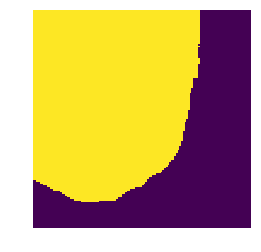

In [49]:
show_img(probs[idx]>0.5);

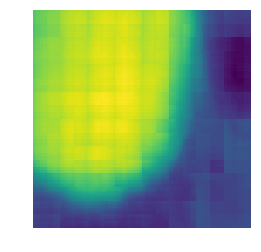

In [50]:
show_img(probs[idx]);

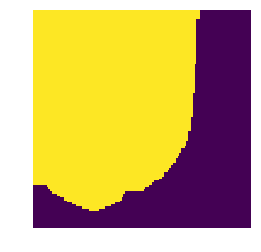

In [51]:
show_img(y[idx]);

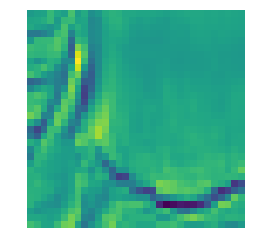

In [52]:
show_img(x[idx][0]);

# Optimise threshold

In [53]:
def resize_img(fn):
    return np.array(Image.fromarray(fn).resize((101,101)))

resizePreds = np.array([resize_img(x) for x in probs])
resizeY = np.array([resize_img(x) for x in y])

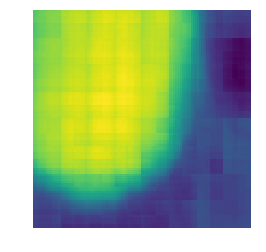

In [54]:
show_img(resizePreds[idx]);

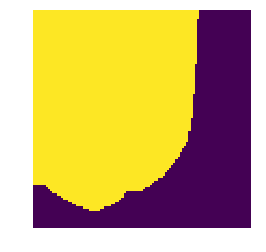

In [55]:
show_img(resizeY[idx]);

In [56]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [57]:
thres = np.linspace(-1, 1, 10)
thres_ioc = [iou_metric_batch(resizeY, np.int32(resizePreds > t)) for t in tqdm_notebook(thres)]

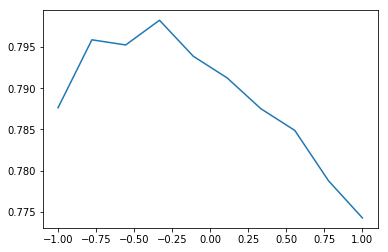

In [58]:
plt.plot(thres, thres_ioc);

In [59]:
best_thres = thres[np.argmax(thres_ioc)]
best_thres, max(thres_ioc)

(-0.33333333333333337, 0.79825)

In [60]:
thres = np.linspace(-0.75, 0.25, 50)
thres_ioc = [iou_metric_batch(resizeY, np.int32(resizePreds > t)) for t in tqdm_notebook(thres)]

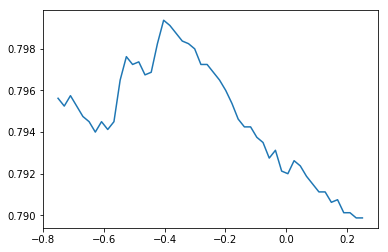

In [61]:
plt.plot(thres, thres_ioc);

In [62]:
best_thres = thres[np.argmax(thres_ioc)]
best_thres, max(thres_ioc)

(-0.4030612244897959, 0.799375)

In [34]:
best_thres=-0.4030612244897959

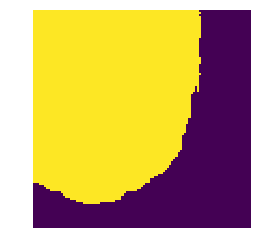

In [64]:
show_img(resizePreds[0]>best_thres);

# Run on test

In [35]:
sz=128
bs=64

In [36]:
(PATH/'test-128').mkdir(exist_ok=True)

In [37]:
def resize_img(fn):
    Image.open(fn).resize((128,128)).save((fn.parent.parent)/'test-128'/fn.name)

files = list((PATH/'test').iterdir())
with ThreadPoolExecutor(8) as e: e.map(resize_img, files)

In [38]:
testData = np.array(glob(f'{PATH}/test-128/*'))

In [39]:
class TestFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.fnames[i]))
    def get_c(self): return 0

In [40]:
tfms=tfms_from_model(resnext50, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(TestFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, test=testData, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

In [41]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [42]:
learn = ConvLearner(md, models)

In [43]:
learn.load('model_4')

In [44]:
x,y = next(iter(md.test_dl))
py = to_np(learn.model(V(x)))

In [45]:
x.shape

torch.Size([64, 3, 128, 128])

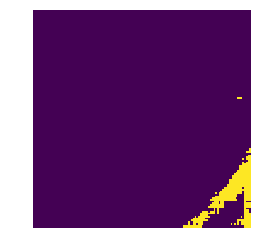

In [46]:
show_img(py[6]>best_thres);

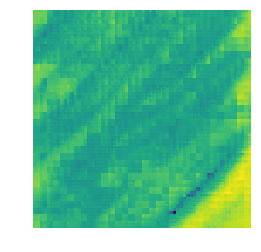

In [47]:
show_img(py[6]);

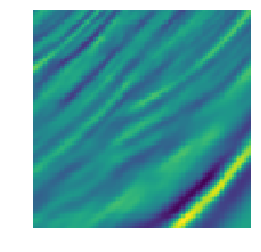

In [48]:
show_img(y[6]);

In [49]:
py.shape

(64, 128, 128)

In [50]:
probs, y = predict(md, nSplits, models, (len(testData), sz, sz), test=True)

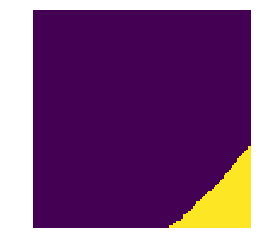

In [65]:
show_img(probs[6]>best_thres);

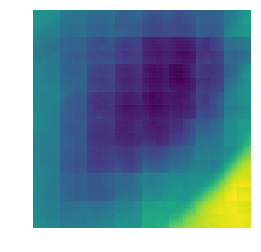

In [66]:
show_img(probs[6]);

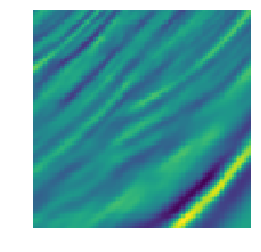

In [67]:
show_img(y[6]);

In [68]:
def resize_img(fn):
    return np.array(Image.fromarray(fn).resize((101,101)))

resizePreds = np.array([resize_img(x) for x in probs])

In [69]:
resizePreds.shape

(18000, 101, 101)

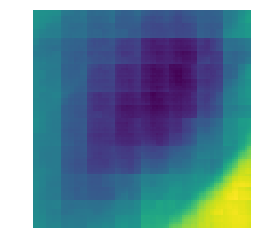

In [70]:
show_img(resizePreds[6]);

In [71]:
testData

array(['/home/giles/Downloads/fastai_data/salt/test-128/ac26efe98e.png',
       '/home/giles/Downloads/fastai_data/salt/test-128/0a5eac8775.png',
       '/home/giles/Downloads/fastai_data/salt/test-128/bdb1c1fcbf.png', ...,
       '/home/giles/Downloads/fastai_data/salt/test-128/3bceaa0303.png',
       '/home/giles/Downloads/fastai_data/salt/test-128/96867a3897.png',
       '/home/giles/Downloads/fastai_data/salt/test-128/52f6267e3f.png'], dtype='<U62')

In [72]:
f'{PATH}/test'

'/home/giles/Downloads/fastai_data/salt/test'

In [73]:
test_ids = next(os.walk(f'{PATH}/test'))[2]

In [74]:
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

In [75]:
pred_dict = {id_[:-4]:RLenc(np.round(resizePreds[i] > best_thres)) for i,id_ in tqdm_notebook(enumerate(test_ids))}

In [76]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')

In [77]:
sub

,rle_mask
id,
ac26efe98e,1 38 102 38 203 38 304 38 405 38 506 38 607 38...
0a5eac8775,
bdb1c1fcbf,
5358961921,
b7b72a69d1,
c1169d47ce,
89eb8ef89f,6463 2 6564 2 6665 2 6765 3 6866 3 6967 3 7065...
696d91b37e,
73053e4d03,1 1 5 2 14 1 102 2 105 3 111 5 203 16 304 15 4...
